In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from scipy.stats import linregress

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams['font.family'] = 'agency fb'
plt.rcParams['font.sans-serif'] = 'Georgia'
plt.rcParams['font.size'] = 15

# 1 - Data Analysis and Data Wrangling

First of all, after investigating the data carefully, I have seen that 33.42% of the data were shifted under wrong columns in our initial dataset.

Since last 382 rows have no campaign_id and fb_campaign_id, data were shifted to two columns left. By moving data under the right columns, I could save 33.42% of the data without having a campaign_id and fb_campaign_id for those rows. 

I will use predictive machine learning model to predict missing campaign_id's in the dataset.

Rows with missing campaign_id's will be predicted by building a Random Forest Classifier model.

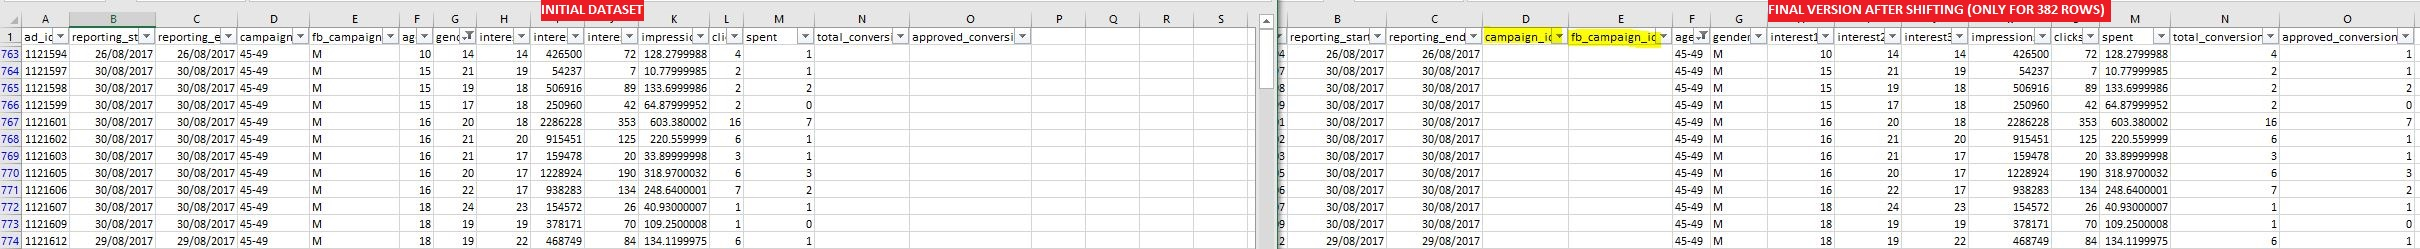

In [3]:
df = pd.read_csv('data/data_for_data_analytics_intern_revised.csv',sep=',')
df_backup = df.copy()
df.head()

,ad_id,reporting_start,reporting_end,campaign_id,fb_campaign_id,age,gender,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion
0,708746,17/08/2017,17/08/2017,916.0,103916.0,30-34,M,15,17,17,7350,1,1.43,2,1
1,708749,17/08/2017,17/08/2017,916.0,103917.0,30-34,M,16,19,21,17861,2,1.82,2,0
2,708771,17/08/2017,17/08/2017,916.0,103920.0,30-34,M,20,25,22,693,0,0.00,1,0
3,708815,30/08/2017,30/08/2017,916.0,103928.0,30-34,M,28,32,32,4259,1,1.25,1,0
4,708818,17/08/2017,17/08/2017,916.0,103928.0,30-34,M,28,33,32,4133,1,1.29,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ad_id                1143 non-null   int64  
 1   reporting_start      1143 non-null   object 
 2   reporting_end        1143 non-null   object 
 3   campaign_id          761 non-null    float64
 4   fb_campaign_id       761 non-null    float64
 5   age                  1143 non-null   object 
 6   gender               1143 non-null   object 
 7   interest1            1143 non-null   int64  
 8   interest2            1143 non-null   int64  
 9   interest3            1143 non-null   int64  
 10  impressions          1143 non-null   int64  
 11  clicks               1143 non-null   int64  
 12  spent                1143 non-null   float64
 13  total_conversion     1143 non-null   int64  
 14  approved_conversion  1143 non-null   int64  
dtypes: float64(3), int64(8), object(4)
mem

### To be investigated;
    a- ad_id has to be unique - check if any duplicates.
    b- campaign_id, age, interest1 ,interest2 and interest3 columns have categorized variables. How many groups are categorized? Check dtypes
    c- define performance related metrics
    d- how long does each campaign last?
    e -382 missing data points on campaign_id & fb_campaign_id - since it's the 33.42% of the data, and campaign_id is one of the most important features, ML model will be created to predict those data points. 

In [5]:
'''
a - Checking if advertisement_id's are unique
'''
print(len(df.ad_id.unique()) == df.shape[0])


'''
b - Checking categorical variables
'''
for column in ['campaign_id','age','interest1','interest2','interest3']:
    #print(df[column].unique())
    break
    
# Convering campaign_id to categorical variable
df['campaign_id'] = df['campaign_id'].astype('object')
df['interest1'] = df['interest1'].astype('object')
df['interest2'] = df['interest2'].astype('object')
df['interest3'] = df['interest3'].astype('object')


# There are 3 different campaigns in total + NaN from the last 382 rows with unknown campaign
# Age is grouped into 4 category.
# As for interests, each number corresponds to a specific facebook user segment.

True


### Adding performance related metrics
    - Click-through rate
    - Conversion rate
    - Cost per click

In [6]:
# Creating click-through rate
df['ctr'] = (df['clicks']/df['impressions'])*100

# Creating conversion rate
df['cr'] = (df['approved_conversion']/df['clicks'])*100

# Creating cost per click
df['cpc'] = (df['spent']/df['clicks'])

# Since for some campaigns we have indefinite cpc (ie: 0/0), those NaN data converted to 0 which means they don't contribute any value or don't cost any price.
# Also w have cases where clicks = 0 but approved_conversion is higher than 0. This could be because of delay. 0.069% of the dataset which is quite low. Those cases are excluded from the dataset in order to perform predictive analysis.

df.drop(df[df.clicks < df.approved_conversion].index, inplace=True)
df = df.reset_index().drop('index',axis=1)
df['cpc'] = df['cpc'].fillna(0)
df['cr'] = df['cr'].fillna(0)

In [7]:
'''
c - Calculating campaigns duration for whole dataset
'''

# First converting object dtpye into datetime64 for date columns
df['reporting_start'] =  pd.to_datetime(df['reporting_start'], format='%d/%m/%Y')
df['reporting_end'] = pd.to_datetime(df['reporting_end'], format='%d/%m/%Y')

# Taking difference to see how long each campaign lasts
campaign_length = (df.reporting_start - df.reporting_end)
print(campaign_length.unique())

'''
Each campaign run in August,2017 and each of them lasts only 1 day.
Starting date: 17/08/2017
Ending date: 30/08/2017
'''

[0]


'\nEach campaign run in August,2017 and each of them lasts only 1 day.\nStarting date: 17/08/2017\nEnding date: 30/08/2017\n'

## Building Predictive Model -  Random Forest

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071 entries, 0 to 1070
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ad_id                1071 non-null   int64         
 1   reporting_start      1071 non-null   datetime64[ns]
 2   reporting_end        1071 non-null   datetime64[ns]
 3   campaign_id          689 non-null    object        
 4   fb_campaign_id       689 non-null    float64       
 5   age                  1071 non-null   object        
 6   gender               1071 non-null   object        
 7   interest1            1071 non-null   object        
 8   interest2            1071 non-null   object        
 9   interest3            1071 non-null   object        
 10  impressions          1071 non-null   int64         
 11  clicks               1071 non-null   int64         
 12  spent                1071 non-null   float64       
 13  total_conversion     1071 non-nul

In [9]:
# Creating dummy variables for predictive ML
df_dum = pd.get_dummies(df,columns=['gender'])
df_dum = df_dum[['ctr','cr','cpc','gender_F','gender_M','campaign_id']]
df_dum['campaign_id'] = df_dum['campaign_id'].astype('float')

# Dividing dataset into two, training data with correct values
X = df_dum.drop(columns='campaign_id',axis=1).iloc[:689]
y = df_dum['campaign_id'].iloc[:689]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

# fitting scaler on training data
norm = MinMaxScaler().fit(X_train)

# transforming training data
X_train_norm = norm.transform(X_train)

# transforming testing data
X_test_norm = norm.transform(X_test)

# creating model
rf_model = RandomForestClassifier(random_state=42)

# fitting model
rf_model.fit(X_train,y_train)

# predicting outcome
y_pred_rf = rf_model.predict(X_test)

# Checking Accuracy
print("Accuracy score is {:.2f}.".format(accuracy_score(y_test,y_pred_rf)))

pd.DataFrame({"Actual":y_test,"Predicted":y_pred_rf}).sample(8)

# Our model accuracy is more than 84%. With this accuracy, I'll predict missing campaign_id's for our dataset.

Accuracy score is 0.85.


,Actual,Predicted
81,936.0,936.0
180,936.0,936.0
88,936.0,936.0
13,916.0,916.0
161,936.0,936.0
577,1178.0,1178.0
439,936.0,936.0
396,936.0,936.0


In [10]:
# Applying model to find missing campaign_id's

y_pred_rf_unknown = rf_model.predict(df_dum.drop(columns='campaign_id',axis=1).iloc[689:].fillna(0))
predicted_campaigns = pd.DataFrame({"Actual":0,"Predicted":y_pred_rf_unknown})['Predicted']

# Adding predicted values onto main dataframe
for index in np.arange(689,1071):
    df.at[index,'campaign_id'] = predicted_campaigns[index-689]

# Visualization

In [11]:
# Calculating percentage of age distribution
age_by_order = []
for age_group in df.age.unique():
    age_by_order.append(round(df[df['age'] == str(age_group)]['age'].shape[0] / df.shape[0]*100))
    
# Calculating percentage of gender distribution
gender_by_order = []
for gender_group in df.gender.unique():
    gender_by_order.append(round(df[df['gender'] == str(gender_group)]['gender'].shape[0] / df.shape[0]*100))

# Calculating percentage of campaign distribution
campaign_list = []
for campaign in df.campaign_id.unique():
    campaign_list.append(round(df[df['campaign_id'] == campaign]['campaign_id'].shape[0] / df.shape[0]*100))
    
# Replacing campaign_id column with campaign names
df['campaign_id'] = df['campaign_id'].replace({916.0 : 'campaign_a',
                                   936.0 : 'campaign_b',
                                   1178.0 : 'campaign_c'})

'\n- Campaigns mostly focused on young people, more than 50% of the customers are younger than 40.\n- Male users are slightly dominant on this campaigns.\n- Campaign_b has the highest proportion amongst all campaigns in the dataset.(Campaign_a: 7%, Campaign_b: 61%, Campaign_c: 32%)\n'

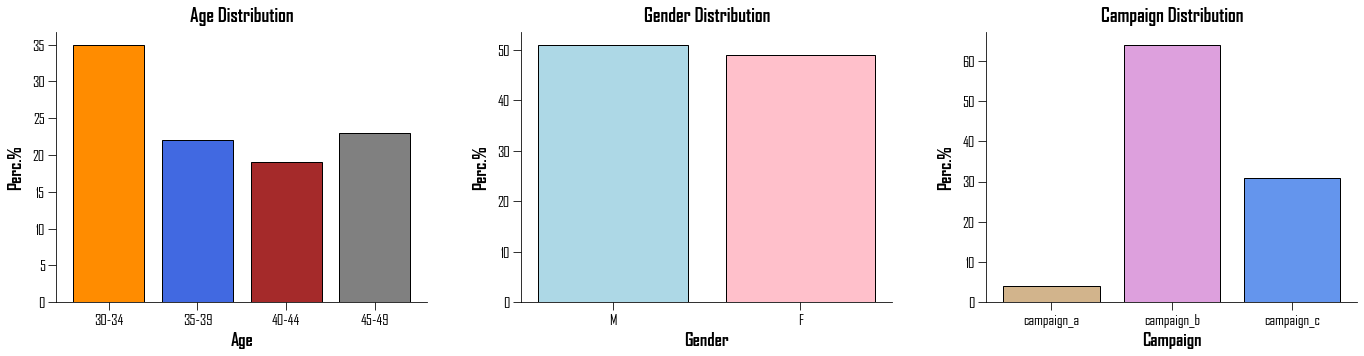

In [12]:
def exploratory_analysis(axes, data, percentages, xlabel, title,colors):
    axes.bar(x=data.unique(), height=percentages, linewidth=1, edgecolor='k', color=[x for x in colors])
    axes.set_xlabel(xlabel,fontweight='bold', size=18)
    axes.set_ylabel('Perc.%',fontweight='bold',size=18,rotation=90,labelpad=8)
    axes.set_title(title,fontweight='bold',size=19,pad=10)
    axes.tick_params(axis='both', which='major', labelsize=15)
    axes.tick_params(size=8)    

fig1, ax = plt.subplots(1,3,figsize=(20,6))

exploratory_analysis(ax[0], df.age, age_by_order,'Age','Age Distribution',colors=['darkorange','royalblue','brown','gray'])
exploratory_analysis(ax[1], df.gender, gender_by_order,'Gender','Gender Distribution',colors=['lightblue','pink'])
exploratory_analysis(ax[2], df.campaign_id, campaign_list,'Campaign','Campaign Distribution',colors=['tan','plum','cornflowerblue'])

fig1.tight_layout(pad=3)
sns.despine()

plt.savefig('figures/exploratory_analysis.png')

'''
- Campaigns mostly focused on young people, more than 50% of the customers are younger than 40.
- Male users are slightly dominant on this campaigns.
- Campaign_b has the highest proportion amongst all campaigns in the dataset.(Campaign_a: 7%, Campaign_b: 61%, Campaign_c: 32%)
'''

"\n1 - CTR is positively correlated with age factor. Older people show more interest in ad's rather than young ones. \n2 - On the other hand, there is a small positive correlation between CR and younge age group, which shows that people in range of 30-34 more tend to buy the product more than other age groups. \n3 - Females are slightly positively correlated with CTR, whereas males are slightly negatively correlated. Which means females show my interest on ad's. \n4 - There is no correlation between gender and campaign_a.\n5 - Campaign_b  positively moderately correlated with Females. This campaign highly focuses on Female customers?\n7 - Campaign_b slightly positively correlated with age group 45-49. Aiming oldest  groups \n8 - Campaign_c slightly negatively correlated with age group 45-49. Aiming younger groups  \n10- Campaign_c has moderately positively correlated with CPC. Considering this campaign focuses only on males and males prefer more luxury ads, positive correlation can be 

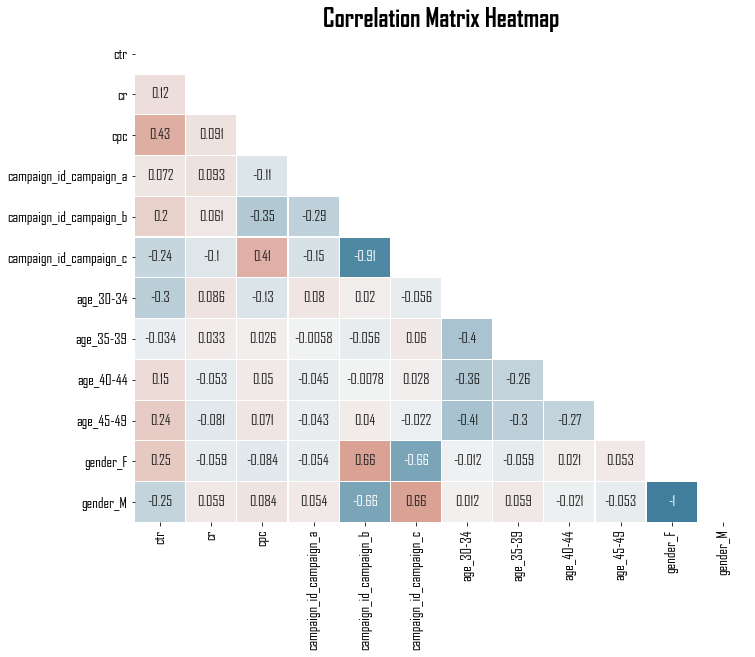

In [13]:
# Converting categorical data to dummy variables
df_dummies = pd.get_dummies(df, columns=['campaign_id','age','gender'])

# Creating correlation matrix
correlation_matrix = df_dummies[['ctr','cr','cpc','campaign_id_campaign_a', 'campaign_id_campaign_b', 'campaign_id_campaign_c',
       'age_30-34', 'age_35-39', 'age_40-44', 'age_45-49', 'gender_F','gender_M']].corr()

# Plot settings
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
fig2, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=0.5, center=0,
            square=False, linewidths=.2 ,cbar=False,annot=True)
plt.title('Correlation Matrix Heatmap',size=25,fontweight='bold')
plt.savefig('figures/correlation_heatmap.png')

'''
1 - CTR is positively correlated with age factor. Older people show more interest in ad's rather than young ones. 
2 - On the other hand, there is a small positive correlation between CR and younge age group, which shows that people in range of 30-34 more tend to buy the product more than other age groups. 
3 - Females are slightly positively correlated with CTR, whereas males are slightly negatively correlated. Which means females show my interest on ad's. 
4 - There is no correlation between gender and campaign_a.
5 - Campaign_b  positively moderately correlated with Females. This campaign highly focuses on Female customers?
7 - Campaign_b slightly positively correlated with age group 45-49. Aiming oldest  groups 
8 - Campaign_c slightly negatively correlated with age group 45-49. Aiming younger groups  
10- Campaign_c has moderately positively correlated with CPC. Considering this campaign focuses only on males and males prefer more luxury ads, positive correlation can be explained.
'''

# CAMPAIGNS

"\n1 - Campaign_a and campaign_b have getting more attention rather than campaign_c\n2 - Campaign_a has the highest conversion rate, with second lowest cost per click.\n3 - Campaign_c has the highest CPC.\n4 - Campaign_c has  the lowest CR.\n\nFindings\n1 - Campaign_a and campaign_b is doing better than campaign_c in terms of CTR which means those campaigns are more effective on reaching customers.\n2 - There's a huge difference on CR for Campaign_a/b and Campaign_C. That means campaign_c performing very poorly. It could be because campaign_C is targeting the wrong customer segment.  campaign_c customers are apparently don't interested in with the product.\n3 - However, we can't see the revenue coming from those campaigns, therefore we can't make certain conclusions about the performance. Even though campaign_C has the lowest CR, we don't know how much revenue it brings to company. (Maybe 1 conversion brings 10K?)\n"

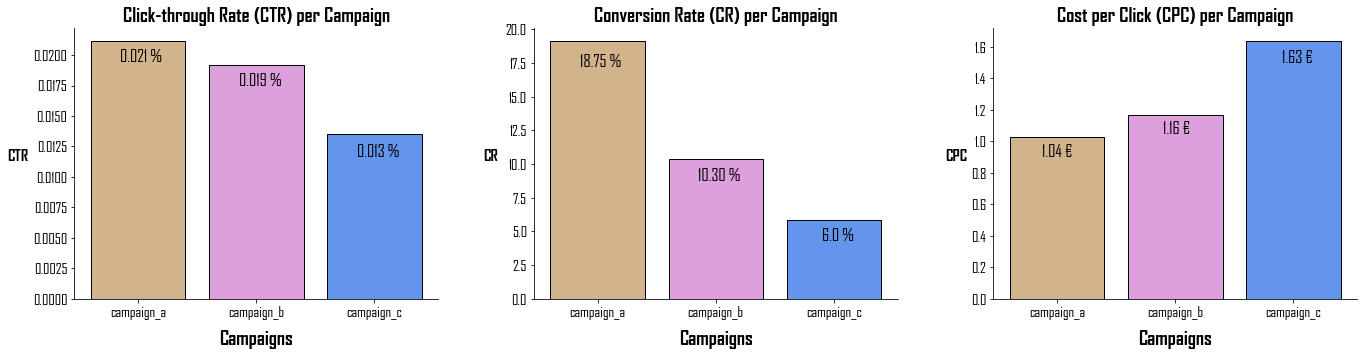

In [14]:
campaign_search = pd.pivot_table(df, index=['campaign_id'], aggfunc='mean')

def campaign_analysis(axes, data, column, title, xlabel, ylabel ,colors):
    axes.bar(x = data.index , height = data[column],linewidth=1,edgecolor='k',color=[x for x in colors])
    axes.set_title(title,size=20,fontweight='bold')
    axes.set_xlabel(xlabel,size=20, fontweight='bold',labelpad=10)
    axes.set_ylabel(ylabel,rotation=0,size=16, fontweight='bold',labelpad=15)
    
fig3, ax = plt.subplots(1,3, figsize=(20,6))

campaign_analysis(ax[0], pd.pivot_table(df, index=['campaign_id'], aggfunc='mean') , 'ctr', 'Click-through Rate (CTR) per Campaign', 'Campaigns', 'CTR', colors=['tan','plum','cornflowerblue'])
campaign_analysis(ax[1], pd.pivot_table(df, index=['campaign_id'], aggfunc='mean') , 'cr', 'Conversion Rate (CR) per Campaign', 'Campaigns', 'CR', colors=['tan','plum','cornflowerblue'])
campaign_analysis(ax[2], pd.pivot_table(df, index=['campaign_id'], aggfunc='mean') , 'cpc', 'Cost per Click (CPC) per Campaign', 'Campaigns','CPC', colors=['tan','plum','cornflowerblue'])

ax[0].text(-.15, .0195, '0.021 %', fontsize=17)
ax[0].text(0.85, .0175, '0.019 %', fontsize=17)
ax[0].text(1.85, .0117, '0.013 %', fontsize=17)
ax[1].text(-.15, 17.25, '18.75 %', fontsize=17)
ax[1].text(0.85,  8.8, '10.30 %', fontsize=17)
ax[1].text(1.9, 4.3, '6.0 %', fontsize=17)
ax[2].text(-.13, 0.9, '1.04 €', fontsize=17)
ax[2].text(0.9, 1.05, '1.16 €', fontsize=17)
ax[2].text(1.9, 1.5, '1.63 €', fontsize=17)

fig3.tight_layout(pad=3)
sns.despine()
plt.savefig('figures/campaign_analysis.png')

'''
1 - Campaign_a and campaign_b have getting more attention rather than campaign_c
2 - Campaign_a has the highest conversion rate, with second lowest cost per click.
3 - Campaign_c has the highest CPC.
4 - Campaign_c has  the lowest CR.

Findings
1 - Campaign_a and campaign_b is doing better than campaign_c in terms of CTR which means those campaigns are more effective on reaching customers.
2 - There's a huge difference on CR for Campaign_a/b and Campaign_C. That means campaign_c performing very poorly. It could be because campaign_C is targeting the wrong customer segment.  campaign_c customers are apparently don't interested in with the product.
3 - However, we can't see the revenue coming from those campaigns, therefore we can't make certain conclusions about the performance. Even though campaign_C has the lowest CR, we don't know how much revenue it brings to company. (Maybe 1 conversion brings 10K?)
'''

# GENDER

"\n1 - Even though Female customers' CTR is higher than males, male customers have 25% higher CR. (also seen in the correlation heatmap.)\n2 - We are targeting wrong customer group, focus should be males since male customers have higher chance of bringing revenue.\n"

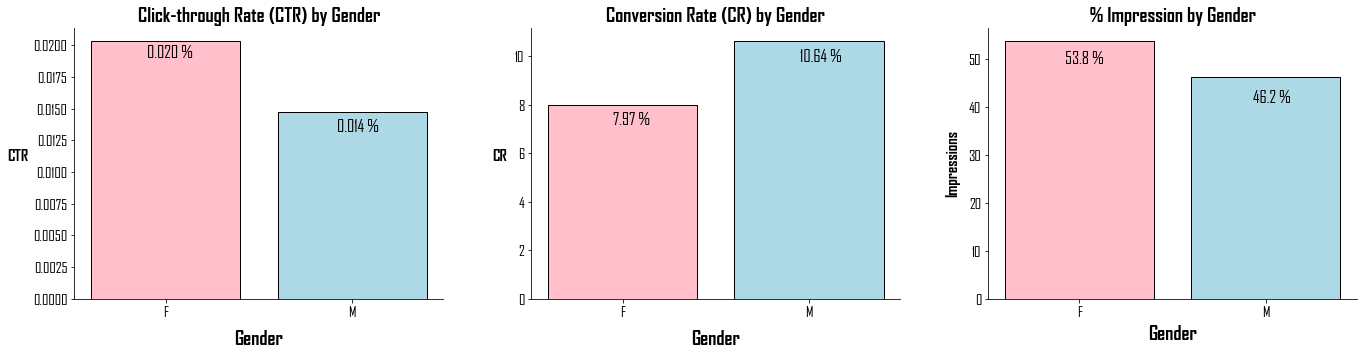

In [15]:
gender_search = pd.pivot_table(df, index='gender',aggfunc='mean')

male_impressions = df.groupby('gender').sum().impressions[1]
female_impressions = df.groupby('gender').sum().impressions[0]
male_imp_per = male_impressions/df.impressions.sum()*100
female_imp_per = female_impressions/df.impressions.sum()*100

def gender_analysis(axes, data, column,  title, xlabel, ylabel, colors):
    axes.bar(x = data.index , height = data[column],linewidth=1,edgecolor='k',color=[x for x in colors])
    axes.set_title(title,size=20,fontweight='bold')
    axes.set_xlabel(xlabel,size=20, fontweight='bold',labelpad=10)
    axes.set_ylabel(ylabel,rotation=0,size=16, fontweight='bold',labelpad=15)
    
fig4, ax = plt.subplots(1,3, figsize=(20,6))

gender_analysis(ax[0], pd.pivot_table(df, index='gender',aggfunc='mean') , 'ctr', 'Click-through Rate (CTR) by Gender', 'Gender', 'CTR', colors=['pink','lightblue'])
gender_analysis(ax[1], pd.pivot_table(df, index='gender',aggfunc='mean') , 'cr', 'Conversion Rate (CR) by Gender', 'Gender', 'CR', colors=['pink','lightblue'])


ax[2].bar(x = gender_search.index, height = [female_imp_per,male_imp_per],linewidth=1,edgecolor='k',color=['pink','lightblue'])
ax[2].set_title('% Impression by Gender',size=20,fontweight='bold')
ax[2].set_xlabel('Gender',size=20, fontweight='bold',labelpad=5)
ax[2].set_ylabel('Impressions',rotation=90,size=16, fontweight='bold',labelpad=8)


ax[0].text(-.10, .0190, '0.020 %', fontsize=17)
ax[0].text(0.92, .0132, '0.014 %', fontsize=17)
ax[1].text(-.05, 7.2, '7.97 %', fontsize=17)
ax[1].text(0.95, 9.8, '10.64 %', fontsize=17)
ax[2].text(-0.08, 49, '53.8 %', fontsize=17)
ax[2].text(0.93, 41, '46.2 %', fontsize=17)


fig4.tight_layout(pad=3)
sns.despine()
plt.savefig('figures/gender_analysis.png')

'''
1 - Even though Female customers' CTR is higher than males, male customers have 25% higher CR. (also seen in the correlation heatmap.)
2 - We are targeting wrong customer group, focus should be males since male customers have higher chance of bringing revenue.
'''

"\n1 - We should change our target group for campaign_b specifically. Even though ad's are mostly shown to females  and even though CTR is higher for female customers, still the convertion rate is almost doubled by male customers.\n"

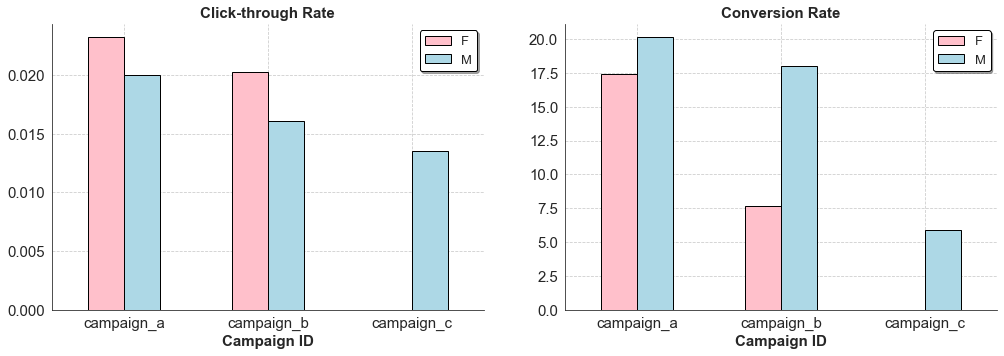

In [16]:
sns.set_style("white")

df_gender_camp = df.groupby(['campaign_id','gender']).mean()

fig5, ax = plt.subplots(1,2, figsize=(15,6))

df_gender_camp['ctr'].unstack().plot(kind='bar',title='ctr',ax=ax[0],edgecolor='k', linewidth=1,color=['pink','lightblue'])
ax[0].set_title('Click-through Rate',size=15,fontweight='bold')
ax[0].set_xticklabels(labels=['campaign_a','campaign_b','campaign_c'],rotation=0)
ax[0].set_xlabel('Campaign ID',fontweight='bold')
ax[0].legend(edgecolor='k',fontsize=13,shadow=True)
ax[0].grid(linestyle='--')


df_gender_camp['cr'].unstack().plot(kind='bar',title='cr',ax=ax[1],edgecolor='k', linewidth=1,color=['pink','lightblue'])
ax[1].set_title('Conversion Rate',size=15,fontweight='bold')
ax[1].set_xlabel('Campaign ID',fontweight='bold')
ax[1].set_xticklabels(labels=['campaign_a','campaign_b','campaign_c'],rotation=0)
ax[1].legend(edgecolor='k',fontsize=13,shadow=True)
ax[1].grid(linestyle='--')

fig5.tight_layout(pad=3)
sns.despine()
plt.savefig('figures/deep_gender_analysis.png')

'''
1 - We should change our target group for campaign_b specifically. Even though ad's are mostly shown to females  and even though CTR is higher for female customers, still the convertion rate is almost doubled by male customers.
'''


# AGE

"\n1 - Even though people +40 yo. have higher CTR than people -40 yo., CR is higher for younger age groups.\n2 - Even though youngest age group and oldest age group exposed to close % of impressions, youngest group's CR is double times higher than oldest group.\n3 - We should focus on younger age in our campaigns in order to increase CR. \n"

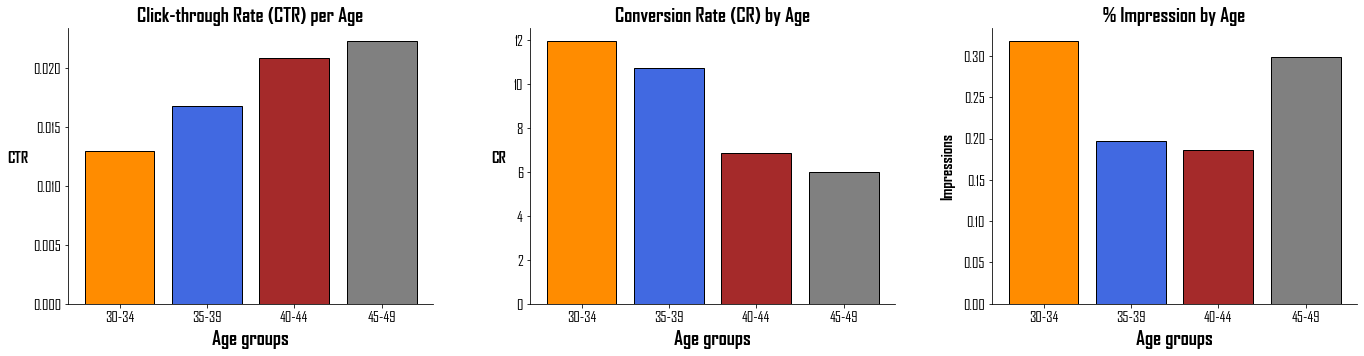

In [17]:
sns.reset_orig()
plt.rcParams['font.family'] = 'agency fb'
plt.rcParams['font.sans-serif'] = 'Georgia'
plt.rcParams['font.size'] = 15

age_search = pd.pivot_table(df, index='age',aggfunc='mean')

age_30_34 = df.groupby('age').sum().impressions[0]/df.impressions.sum()
age_35_39 = df.groupby('age').sum().impressions[1]/df.impressions.sum()
age_40_44 = df.groupby('age').sum().impressions[2]/df.impressions.sum()
age_45_49 = df.groupby('age').sum().impressions[3]/df.impressions.sum()

def age_analysis(axes, data, column, title, xlabel, ylabel ,colors):
    axes.bar(x = data.index , height = data[column],linewidth=1,edgecolor='k',color=[x for x in colors])
    axes.set_title(title,size=20,fontweight='bold')
    axes.set_xlabel(xlabel,size=20, fontweight='bold',labelpad=5)
    axes.set_ylabel(ylabel,rotation=0,size=16, fontweight='bold',labelpad=15)
    
fig6, ax = plt.subplots(1,3, figsize=(20,6))

age_analysis(ax[0], pd.pivot_table(df, index='age',aggfunc='mean'), 'ctr', 'Click-through Rate (CTR) per Age', 'Age groups', 'CTR', colors=['darkorange','royalblue','brown','gray'])
age_analysis(ax[1], pd.pivot_table(df, index='age',aggfunc='mean'), 'cr', 'Conversion Rate (CR) by Age', 'Age groups', 'CR', colors=['darkorange','royalblue','brown','gray'])

ax[2].bar(x = age_search.index, height = [age_30_34,age_35_39,age_40_44,age_45_49],linewidth=1,edgecolor='k',color=['darkorange','royalblue','brown','gray'])
ax[2].set_title('% Impression by Age',size=20,fontweight='bold')
ax[2].set_xlabel('Age groups',size=20, fontweight='bold',labelpad=5)
ax[2].set_ylabel('Impressions',rotation=90,size=16, fontweight='bold',labelpad=8)

fig6.tight_layout(pad=3)
sns.despine()

plt.savefig('figures/age_analysis.png')

'''
1 - Even though people +40 yo. have higher CTR than people -40 yo., CR is higher for younger age groups.
2 - Even though youngest age group and oldest age group exposed to close % of impressions, youngest group's CR is double times higher than oldest group.
3 - We should focus on younger age in our campaigns in order to increase CR. 
'''

'\n1 - Campaign_a should focus on age group 40-44 since this group has almost two times CR compared to other age groups.\n2 - Even though campaign_b focused on older age group, focus should be swapped to younger age group considering younger age groups CR is more than more than twice of older age groups.\n3 - Campaign_c mostly focused on older age groups, yet again most conversion comes from younger age groups.\n'

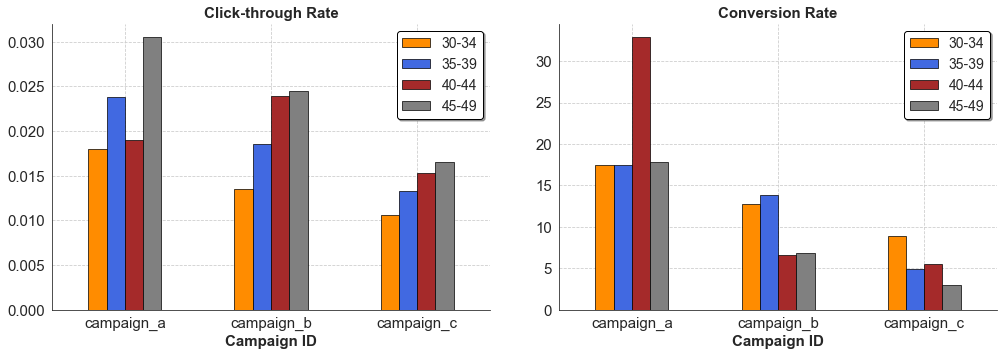

In [18]:
df_age_camp = df.groupby(['campaign_id','age']).mean()
sns.set_style("white")

fig7, ax = plt.subplots(1,2, figsize=(15,6))

df_age_camp['ctr'].unstack().plot(kind='bar',title='ctr',ax=ax[0],edgecolor='k', linewidth=0.7,color=['darkorange','royalblue','brown','gray'])
ax[0].set_title('Click-through Rate',size=15,fontweight='bold')
ax[0].set_xticklabels(labels=['campaign_a','campaign_b','campaign_c'],rotation=0)
ax[0].set_xlabel('Campaign ID',fontweight='bold')
ax[0].legend(edgecolor='k',fontsize=14,shadow=True)
ax[0].grid(linestyle='--')


df_age_camp['cr'].unstack().plot(kind='bar',title='cr',ax=ax[1],edgecolor='k', linewidth=0.7,color=['darkorange','royalblue','brown','gray'])
ax[1].set_title('Conversion Rate',size=15,fontweight='bold')
ax[1].set_xlabel('Campaign ID',fontweight='bold')
ax[1].set_xticklabels(labels=['campaign_a','campaign_b','campaign_c'],rotation=0)
ax[1].legend(edgecolor='k',fontsize=14,shadow=True)
ax[1].grid(linestyle='--')

fig7.tight_layout(pad=3)

sns.despine()
plt.savefig('figures/deep_age_analysis.png')

'''
1 - Campaign_a should focus on age group 40-44 since this group has almost two times CR compared to other age groups.
2 - Even though campaign_b focused on older age group, focus should be swapped to younger age group considering younger age groups CR is more than more than twice of older age groups.
3 - Campaign_c mostly focused on older age groups, yet again most conversion comes from younger age groups.
'''

# STATISTICAL ANALYSIS

In [19]:
def slope_calculator(x,y):
    result = stats.linregress(x,y)
    slope = result[0]
    return slope

campaign_a = df[df['campaign_id'] == 'campaign_a']
campaign_b = df[df['campaign_id'] == 'campaign_b']
campaign_c = df[df['campaign_id'] == 'campaign_c']

campaign_a_slope = slope_calculator(campaign_a['impressions'],campaign_a['approved_conversion'])
campaign_b_slope = slope_calculator(campaign_b['impressions'],campaign_b['approved_conversion'])
campaign_c_slope = slope_calculator(campaign_c['impressions'],campaign_c['approved_conversion'])

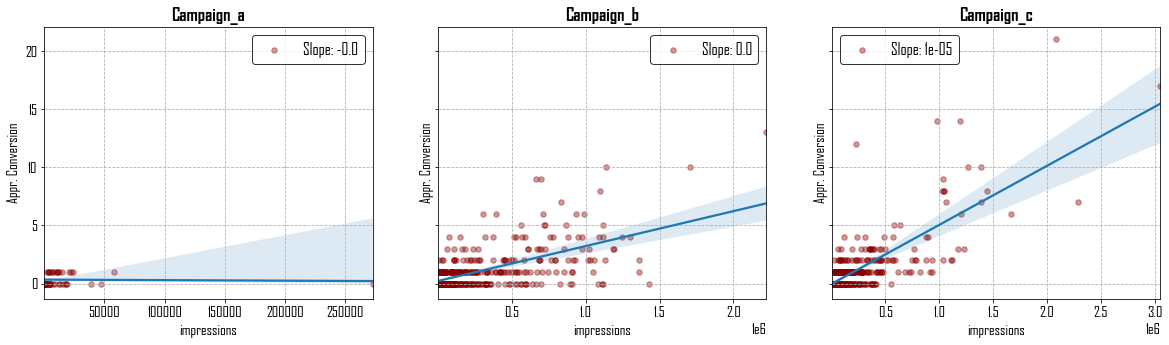

In [20]:
sns.reset_orig()
plt.rcParams['font.family'] = 'agency fb'
plt.rcParams['font.sans-serif'] = 'Georgia'
plt.rcParams['font.size'] = 15

def regression_analysis(df,axes,campaign_name,slope_value):
    sns.regplot(x='impressions',y='approved_conversion', data=df, ax=axes, fit_reg=True, 
                scatter_kws={"color":"darkred","alpha":0.4,"s":30},label=('Slope: '+str(round(slope_value,5))))
    axes.set_title(campaign_name,size=18,fontweight='bold')
    axes.set_xlabel('impressions')
    axes.set_ylabel('Appr. Conversion')
    axes.grid(True,linestyle='--')
    axes.legend(fontsize=16,edgecolor='k')

    
fig8, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True,figsize=(20,5))

regression_analysis(campaign_a,ax1,'Campaign_a',campaign_a_slope)
regression_analysis(campaign_b,ax2,'Campaign_b',campaign_b_slope)
regression_analysis(campaign_c,ax3,'Campaign_c',campaign_c_slope)

plt.savefig('figures/regression_analysis.png')